### Описание задачи

Оценить возможное качество работы алгоритма для задачи анализа тональности отзывов на товары на русском языке. Предоставлена только небольшая тестовая выборка, данные для обучения нужно получить самостоятельно. 

Оценка качества в этом задании реализована через контест на Kaggle Inclass:

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis

Метрика - Accuracy, таргет - строго больше 85%.

### 1. Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import pymorphy2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
with open('test.csv', 'r', encoding='utf-8') as f:
    test = f.read()   
    soup = BeautifulSoup(test, 'html.parser')
    test = [line.get_text() for line in soup.find_all('review')]

In [3]:
print(test[0])
print(test[1])
print(test[2])

Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти.
Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться.

ценанадежность-неубиваемостьдолго держит батарею 4 дня стабильно как телефон, 3-4 как плеер если 
постоянно долбиться в уши и звонить по паре часо на дню, игры и, конечно,  смс , в месяц около 200 шт набирается.
 Максимальное время работы 5 дней в щадящем режиме.2 simqwerty рулит -после нее набор смс на обычных сенсорниках и кнопочных

Судя по всему наш датасет - это отзывы на мобильные телефоны. Попробуем получить данные с какого-нибудь сайта с обзорами техники.

### 2.  Парсинг

Попытка парсить данные с Яндекс.Маркета не увенчалась успехом - подозрительное поведение быстро детектится и все рушится из-за капчи. Нашел сайт попроще - top-tehnica.ru. 140 страниц отзывов на телефоны с оценкой по пятибальной шкале и графами "Достоинства", "Недостатки" и "Комментарий". Просмотрев отзывы я пришел к выводу, что оценка - плохой индикатор тональности, т.к. и с 4 звездами отзывы часто отрицательные, поэтому я просто взял "Достоинства" и "Недостатки" со всех отзывов и разметил их как положительные и отрицательные (единицы и нули). После чего удалил все короткие отзывы (меньше 26 знаков), так как они могли состоять из одного "Нет" и являлись малоиформативными.

In [4]:
# формула для извлечения текста из html-кода
def text(data, tag, clas):
    try:
        text = data.find(tag, clas).text
        text = re.sub('\s+',' ',text).strip()
    except:
        text = ''
    return text

In [5]:
# после удачного парсинга закомментировал код и сохранил полученные данные в csv-файл

'''
pos_reviews = []
neg_reviews = []
for i in range(1, 141):
    url = 'https://top-tehnica.ru/telefony?page=' + str(i)
    req = requests.get(url)
    parser = BeautifulSoup(req.text, 'html')
    for review in parser.find_all('div', 'right reviews features price'):
        plus = text(review, 'div', 'plus desc')
        minus = text(review, 'div', 'minus desc') 
        pos_reviews.append(plus)
        neg_reviews.append(minus)
        
labels = [1] * len(pos_reviews) + [0] * len(neg_reviews)
reviews = pos_reviews + neg_reviews
data = pd.DataFrame({'text': reviews, 'label': labels})

data = data[data.text.str.len() > 25].reset_index(drop=True)

data.to_csv('data.csv')
'''

data = pd.read_csv('data.csv', index_col=0)
data.head(5)

,text,label
0,Очень быстрая работа смартфона. Хорошая автоно...,1
1,"Интересная камера, расположение, стабилизация ...",1
2,Практически единственная брендовая раскладушка...,1
3,"Яркий экран,понятное меню.",1
4,"Мне очень понравился его экран, все-таки супер...",1


In [6]:
data.tail(5)

,text,label
5695,Громкая связь перекрывает вас помехами (когда ...,0
5696,Различными нетелефонными функциями на нем не п...,0
5697,"Музыка - только в гарнитуре, через динамик слу...",0
5698,"Java тормозит, динамик слабоват",0
5699,"На мой взгляд самое главное, это качество связ...",0


### 3. Предобработка, обучение и тест

Удалим пунктуацию, лишние символы, латиницу и ламматизируем слова.

In [7]:
morph = pymorphy2.MorphAnalyzer()

def preprocessing(data):
    corpus = []

    for i in range(len(data)):
    
        # оставляем только буквы и приводим к нижнему регистру
        text = re.sub('[^а-яА-Я]', ' ', data[i]).lower()
    
        # преобразуем комментарий в список
        text = text.split()
    
        # лемматизируем
        text = [str(morph.parse(word)[0].normal_form) for word in text]
    
        # собираем список обратно
        text = ' '.join(text)
    
        corpus.append(text)
        
    return corpus

In [8]:
corpus = preprocessing(data.text)
test_corpus = preprocessing(test)

print(corpus[0])

очень быстрый работа смартфон хороший автономность


Векторизуем текст при помощи TF-IDF. Добавим биграммы и зададим минимальный порог вхождения в весь корпус.

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
X = vectorizer.fit_transform(corpus)
X_test = vectorizer.transform(test_corpus)

y = data.label

X.shape

(5700, 12528)

Посмотрим получится ли пробить таргет с помощью логистической регрессии.

In [10]:
logreg = LogisticRegression().fit(X, y)
predictions = logreg.predict(X_test)

In [11]:
submission = pd.read_csv('sample_submission.csv')
submission.head()

,Id,y
0,0,neg
1,1,neg
2,2,neg
3,3,neg
4,4,neg


In [12]:
submission['y'] = predictions
submission.y.replace(0, 'neg', inplace=True)
submission.y.replace(1, 'pos', inplace=True)
submission.head()

,Id,y
0,0,neg
1,1,neg
2,2,neg
3,3,neg
4,4,pos


In [13]:
submission.to_csv('submission.csv', index=False)

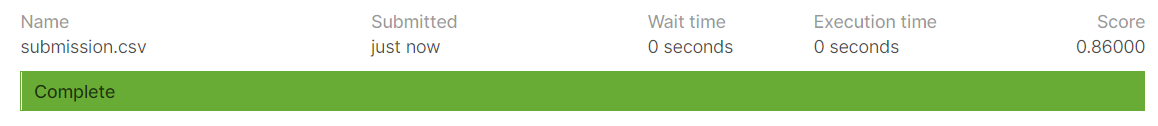

Удалось получить Accuracy больше 85% - поставленная задача выполнена.